# Fix pathing

In [1]:
import sys


sys.path.append("../..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import matplotlib.pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display


# Constants

In [4]:
FOLDER_NAME = "2024_04_12_13_55_09"

FOLDER_PATH = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))), "Simulator", "data", FOLDER_NAME)


# Methods

In [5]:
def load_csv():
    df = pd.read_csv(os.path.join(FOLDER_PATH, "events.csv"))

    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    df['total_response_time'] = df[response_time_cols].sum(axis=1)

    return df


In [6]:
def plot_response_time_density(df):
    matplotlib.pyplot.figure(figsize=(12, 8))

    for triage_category in ["A", "H", "V1"]:
        subset = df[df['triage_impression_during_call'] == triage_category]
        sns.kdeplot(subset['total_response_time'] / 60, bw_adjust=0.5, label=f'Triage {triage_category}', fill=True)

    matplotlib.pyplot.title('Response Time Density by Triage Category')
    matplotlib.pyplot.xlabel('Response Time (minutes)')
    matplotlib.pyplot.ylabel('Density')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()


In [7]:
def print_mean_median(df: pd.DataFrame):
    stats = df.groupby(['triage_impression_during_call', 'urban'])['total_response_time'].agg(['mean', 'median']).reset_index()
    stats['mean'] = (stats['mean'] / 60).round(2)
    stats['median'] = (stats['median'] / 60).round(2)
    stats.rename(columns={
        'triage_impression_during_call': 'Triage',
        'mean': 'Mean (min)',
        'median': 'Median (min)',
        'urban': 'Urban'
    }, inplace=True)
    stats['Urban'] = stats['Urban'].map({True: 'Yes', False: 'No'})
    stats.sort_values(by=["Urban", "Triage"], ascending=[False, True], inplace=True)
    IPython.display.display(stats.style.hide(axis='index'))


# Main

In [8]:
df = load_csv()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   time_call_received                     243 non-null    object
 1   triage_impression_during_call          243 non-null    object
 2   grid_id                                243 non-null    int64 
 3   urban                                  243 non-null    bool  
 4   duration_incident_creation             243 non-null    int64 
 5   duration_resource_appointment          243 non-null    int64 
 6   duration_resource_preparing_departure  243 non-null    int64 
 7   duration_dispatching_to_scene          243 non-null    int64 
 8   duration_at_scene                      243 non-null    int64 
 9   duration_dispatching_to_hospital       243 non-null    int64 
 10  duration_at_hospital                   243 non-null    int64 
 11  duration_dispatchin

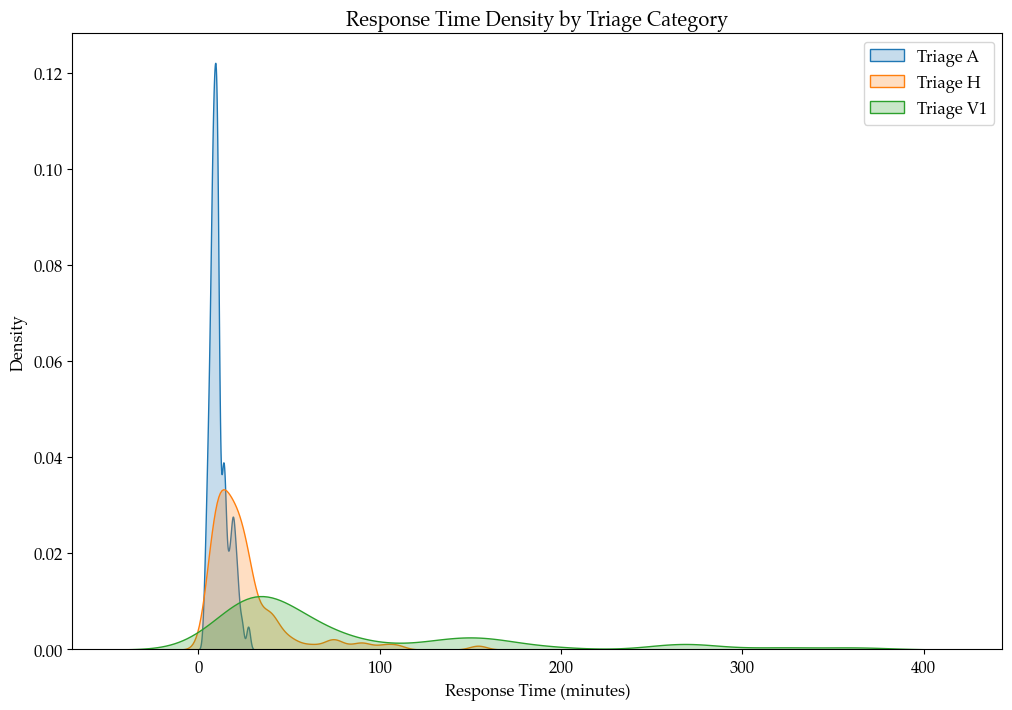

In [9]:
plot_response_time_density(df)


In [10]:
print_mean_median(df)


Triage,Urban,Mean (min),Median (min)
A,Yes,10.670000,9.590000
H,Yes,25.700000,18.720000
V1,Yes,85.360000,50.190000
A,No,16.220000,14.300000
H,No,35.950000,40.020000
V1,No,21.430000,21.430000
